#🧪 Java Antipatterns Scanner (Demo)
This is a small demo for scanning Java antipatterns. It is migrated from a Langflow-based prototype.

##✅ Features
Supports local LLM-based code analysis using the Ollama runtime.

Integrates with a vector database (Chroma) containing structured descriptions of common Java antipatterns.

Uses LangGraph to orchestrate agent-based analysis.

##⚠️ Known Limitations
🔍 Querying method: The system currently uses the raw code snippet as a semantic query, while the database contains natural language descriptions of antipatterns — this may lead to low retrieval accuracy.

👥 Agent structure: The current state only supports a single agent; multi-agent collaboration is not yet implemented.

🌐 Model setup: Only local models (via Ollama) are supported for now; IBM Cloud or other API-based LLMs are not integrated yet.

📎 Usability: There is no user-friendly method to upload code files for analysis — manual modification is required.

In [9]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
import os

# split the text file into chunks and store them in a vector database
loader = TextLoader("/home/ubuntu/ap.txt", encoding="utf-8")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)
split_docs = text_splitter.split_documents(docs)

# Store the split documents in a vector database
embedding = OllamaEmbeddings(model="nomic-embed-text")
persist_dir = os.path.expanduser("~/YourDB")
if not os.path.exists(persist_dir):
    os.makedirs(persist_dir)
vectordb = Chroma(
    embedding_function=embedding,
    persist_directory=persist_dir
)
vectordb.add_documents(split_docs)
vectordb.persist()

print("Successful! Chunk number: ", vectordb._collection.count())

Successful! Chunk number:  9


In [10]:
from langchain_community.chat_models import ChatOllama

from langchain.tools.retriever import create_retriever_tool
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
import os

retriever = vectordb.as_retriever()
retriever_tool = create_retriever_tool(
    retriever,
    name="retrieve_Java_antipatterns",
    description="Search for Java anti-patterns in the codebase",
)

llm = ChatOllama(model="granite3.3:8b")
print(llm.model)

granite3.3:8b


In [11]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph

# Enhanced state definition with context field
class AgentState(TypedDict): 
    code: str # Code to be analyzed
    context: Optional[str] # Retrieved context from knowledge base
    answer: Optional[str] # Analysis result
    
# Template for generating prompts (preserved as requested)
GENERATE_PROMPT = (
    "You are a senior Java code reviewer with deep experience in detecting software design antipatterns. "
    "Below is the code to analyze:\n"
    "{code}\n\n"
    "Here is additional context from the codebase:\n"
    "{context}\n\n"
    "Your task is to:\n"
    "- Carefully analyze the code.\n"
    "- Identify any Java antipatterns or design smells present.\n"
    "- For each antipattern you find, include:\n"
    "  - [Name of the antipattern] (e.g., God Object, Long Method)\n"
    "  - [File or class/method name involved] (if detectable)\n"
    "  - [Brief description] of the issue\n"
    "  - [Why it's a problem]\n"
    "  - [Suggested refactor]\n"
    "Be thorough but concise. If no antipatterns are found, say so."
)

def retrieve_context(state: AgentState):
    """Step 1: Retrieve relevant context from knowledge base using retriever_tool"""
    print("🔍 Step 1: Retrieving context from knowledge base...")
    
    try:
        # Create search query based on code snippet
        search_query = f"Java antipatterns code analysis: {state['code'][:50]}"
        # Use retriever_tool to get relevant context
        context = retriever_tool.invoke({"query": search_query})
        state["context"] = context
        
        print(f"   ✅ Successfully retrieved relevant context")
        
    except Exception as e:
        print(f"   ❌ Error retrieving context: {e}")
        state["context"] = "No additional context available due to retrieval error."
    
    return state

def analyze_antipatterns(state: AgentState):
    """Step 2: Analyze code for antipatterns using retrieved context and LLM"""
    print("🔍 Step 2: Analyzing code for antipatterns...")
    
    try:
        # Format the prompt with code and retrieved context
        prompt = GENERATE_PROMPT.format(
            code=state['code'], 
            context=state.get('context', 'No context available')
        )
        
        # Use LLM to analyze the code
        response = llm.invoke(prompt)
        state["answer"] = response.content if hasattr(response, 'content') else str(response)
        print("   ✅ Analysis completed successfully")
        
    except Exception as e:
        print(f"   ❌ Error during analysis: {e}")
        state["answer"] = f"Error occurred during analysis: {e}"
    
    return state

def display_results(state: AgentState): 
    """Display the final analysis results"""
    print("\n📋 ANTIPATTERN ANALYSIS RESULTS")
    print("=" * 60)
    print(state.get("answer", "No analysis results available."))
    print("=" * 60)
    return state


✅ Enhanced LangGraph workflow with separated context retrieval compiled successfully!


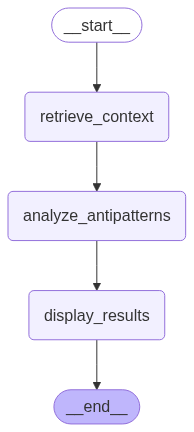

In [12]:
# Create the enhanced LangGraph workflow with separated steps
graph = StateGraph(AgentState)

# Add nodes to the graph - now with 3 distinct steps
graph.add_node("retrieve_context", retrieve_context)
graph.add_node("analyze_antipatterns", analyze_antipatterns)
graph.add_node("display_results", display_results)

# Define the workflow: Retrieve Context → Analyze → Display
graph.set_entry_point("retrieve_context")
graph.add_edge("retrieve_context", "analyze_antipatterns")
graph.add_edge("analyze_antipatterns", "display_results")

# Compile the workflow
agent_pipeline = graph.compile()

print("✅ Enhanced LangGraph workflow with separated context retrieval compiled successfully!")

from IPython.display import display, Image
display(Image(agent_pipeline.get_graph().draw_mermaid_png()))

In [13]:
# Sample legacy code input
legacy_code = """
public class ApplicationManager {
    private List<String> users = new ArrayList<>();
    private List<String> logs = new ArrayList<>();
 
    public void addUser(String user) {
        users.add(user);
        logs.add("User added: " + user);
    }
 
    public void removeUser(String user) {
        users.remove(user);
        logs.add("User removed: " + user);
    }
 
    public void logEvent(String event) {
        logs.add(event);
    }
 
    public void printReport() {
        System.out.println("=== Users ===");
        for (String user : users) {
            System.out.println(user);
        }
 
        System.out.println("=== Logs ===");
        for (String log : logs) {
            System.out.println(log);
        }
    }
 
    public void backupData() {
        // Placeholder: pretend this backs up all data
        System.out.println("Backing up users and logs...");
    }
}
"""

print("🚀 Starting Enhanced Java Antipattern Analysis with Separated RAG Steps")
print("=" * 70)
print(f"📊 Code length: {len(legacy_code)} characters")
print(f"🗄️ Vector DB chunks: {vectordb._collection.count()}")
print("=" * 70)

# Enhanced state initialization - includes context field
initial_state = {
    "code": legacy_code,
    "context": None,
    "answer": None
}

# Run the enhanced pipeline with separated steps
final_state = agent_pipeline.invoke(initial_state)

print(f"\n🎉 Analysis Complete!")
print(f"📝 Final state keys: {list(final_state.keys())}")
print(f"📄 Context retrieved: {'Yes' if final_state.get('context') else 'No'}")
print(f"📋 Analysis completed: {'Yes' if final_state.get('answer') else 'No'}")

🚀 Starting Enhanced Java Antipattern Analysis with Separated RAG Steps
📊 Code length: 898 characters
🗄️ Vector DB chunks: 9
🔍 Step 1: Retrieving context from knowledge base...
   ✅ Successfully retrieved relevant context
🔍 Step 2: Analyzing code for antipatterns...
   ✅ Analysis completed successfully

📋 ANTIPATTERN ANALYSIS RESULTS
1. **Antipattern**: God Object
   - **Class involved**: ApplicationManager
   - **Description**: The class ApplicationManager holds and manages both user data (users list) and log data (logs list), along with methods to manipulate these data and generate reports. This centralizes control over multiple concerns, violating the Single Responsibility Principle (SRP).
   - **Why it's a problem**: It leads to high coupling, making the class difficult to understand, test, and maintain. Changes in one aspect (users or logs) may unintentionally affect other parts of the system.
   - **Suggested refactor**: Separate concerns into distinct classes: UserManager for use